# Comparison between original model and model with delay

Acapacidade média de atendimento por passo em cada um dos modelos comparados deve ser a mesma. Para isso, o número máxmio de servidores no caso com atraso deve ser igual a $S_d$

$$S_d = t_m \cdot S_o$$

onde $t_m$ é o tempo médio de serviço (1+atraso), $S_o$ é o número de servidores no modelo original sem atrasos.

Para um atraso máximo no serviço de 3 passos ($t_{serM} = 3$), com atrasos distribuidos de maneira uniforme, o $t_m$ seria igual a 3. Para que a comparação seja válida, é necessário que $t_m$ seja um inteiro. Para que isso ocorra, $t_serM$ deve ser ímpar.

$$t_m = \frac{((t_{serM}+1)(t_{serM}+2)/2)-1}{t_{serM}} = \frac{2+3+4}{3} = 3 $$

In [4]:
using JuMP
using HiGHS
using Ipopt
using Juniper

include("utils.jl") # demand_generator_mat, printTable, plotData
include("optmize_list.jl")

optimize_list (generic function with 1 method)

### Comon Parametrers

In [ ]:
# Objective function Costs
c_z = 3        # weight of served clients      
c_serd = 2      # weight of server cost
c_L = 1

# Objective function
lin_fobj(S, dr, Cin, phi, Z, L) = c_serd*sum(S) - c_z*sum(Z) +c_L*sum(L)
nonlin_fobj(S, Z, L) = c_sero*sum(S) + c_blro*sum( L./(L .+ Z))


# Parameters
N = 2            # number of examples
horiz = 8        # total horizon

# bounds
XM = 5            # max queue length
YM = 10           # max buffer length before dropping calls
phiM = 9          # max adimission to queue
serMo = 5         # max number of servers original model
tserM = 3         # max delay in service time

tm = (((tserM+1)*(tserM+2)/2)-1)/tserM # average service time
serMd = Int(serMo*tm)                  # max number of servers model with delay

# iniital conditions
X0 = 4
Y0 = 6
L0 = 0
Z0 = 1

struct bounds
    XM
    YM
    phiM
    serM  # different for each model
    tserM # only defined for the model with delay
end
bdso = bounds(XM, YM, phiM, serMo, 0)
bdsd = bounds(XM, YM, phiM, serMd, tserM)

struct initial_conditions
    X0
    Y0
    L0
    Z0
end
ic = initial_conditions(X0, Y0, L0, Z0)

createDemands = true
if createDemands
    d_mat = demand_generator_mat(N, horiz, 14, "uniform", 1)
    a_mat = demand_generator_mat(N, horiz, 2,"uniform",0.5)
else
    d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
    a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";
    d_mat = DelimitedFiles.readdlm(d_fn);
    a_mat = DelimitedFiles.readdlm(a_fn);
end


# costs for the non linear obj func
c_blro = 1000
c_sero = 1

c_serd = c_sero/tm
c_blrd = c_blro



rnd_tser = true
df_input = df_input_generator(horiz, serMd, tserM, rnd_tser);


struct result
    id
    status_opt  
    X
    Y
    Z
    L
    n
    Q
    dr
    phi
    Cin
    S
    Sl
    Sa
    Sst
    Sc
    Sin
    Saux
    J
    c_ser
    c_blr
end

### Original model results

In [6]:
result_os_ori = optimize_list("os_ori");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[1.0, 1.0]

In [7]:
result_om_ori = optimize_list("om_ori");

[1.0, 1.0]

### Delay model results

In [8]:
result_os_del = optimize_list("os_del");

[1.0, 1.0]

In [9]:
result_om_del = optimize_list("om_del");

[1.0, 1.0]

## Results comparison

In [10]:
results_list = [result_os_ori, result_om_ori, result_os_del, result_om_del]

for res in results_list
    # br = res.L[horiz+1]/(res.L[horiz+1]+res.Z[horiz+1])
    br = sum(res.L./(res.L.+res.Z))/N # VERIFICAR QUAL A MELHOR FORMA DE CALCULAR
    total_clients = res.Z[horiz+1]/N
    cost = res.c_ser*sum(res.S) + res.c_blr*br/N

    println(res.id)
    data = hcat(br, total_clients, cost)
    header = (["average blr", "Average served clients", "Average cost"]);
    printTable(data, header)
end

os_ori
Results
┌─────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Average cost │
├─────────────┼────────────────────────┼──────────────┤
│       2.116 │                 10.500 │     1138.032 │
└─────────────┴────────────────────────┴──────────────┘
om_ori
Results
┌─────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Average cost │
├─────────────┼────────────────────────┼──────────────┤
│       2.116 │                 10.500 │     1138.032 │
└─────────────┴────────────────────────┴──────────────┘
os_del
Results
┌─────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Average cost │
├─────────────┼────────────────────────┼──────────────┤
│       1.897 │                 11.500 │     1024.295 │
└─────────────┴────────────────────────┴──────────────┘
om_del
Results
┌─────────────┬────────────────────────┬──────────────┐
│ average blr │ Average served clients │ Ave

os_ori


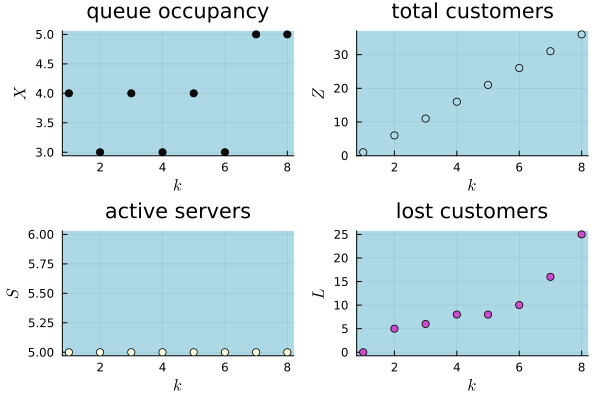

In [11]:
plot_results(result_os_ori, horiz, 1)

om_ori


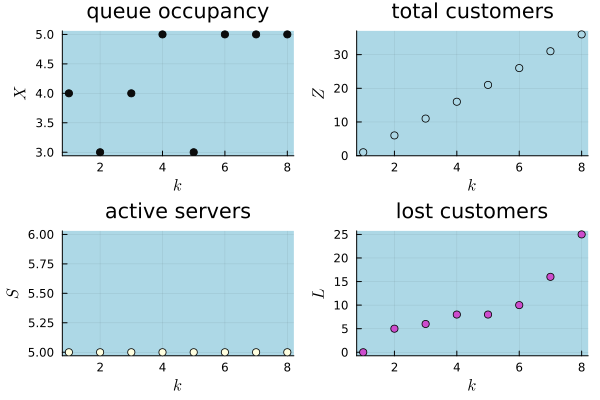

In [12]:
plot_results(result_om_ori, horiz, 1)

os_del


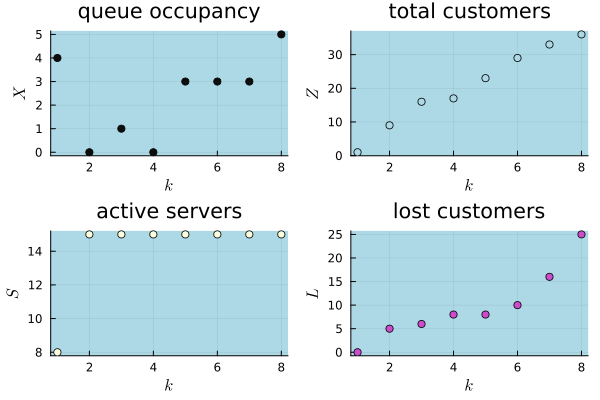

In [13]:
plot_results(result_os_del, horiz, 1)

om_del


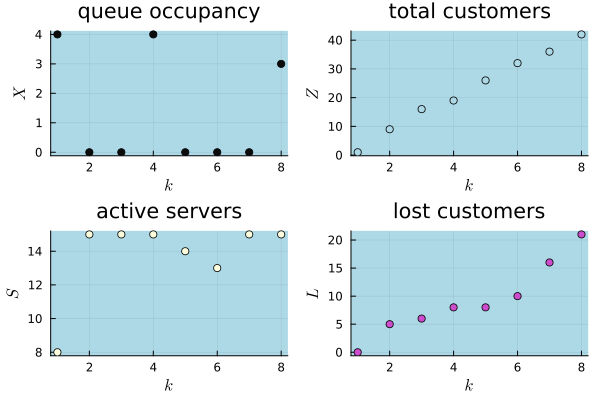

In [14]:
plot_results(result_om_del, horiz, 1)